0820-Copy1が全ての雛形です。  
201027textmining_3_hypertuning  
201110_MGI追加のコピー  
210816 catboost


In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/nlp


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/nlp


#下準備

In [2]:
import pickle
import numpy as np
with open("alldic_0909.pickle", "rb") as f:
  alldic = pickle.load(f)
with open("allnum_0909.pickle", "rb") as f:
  allnum = pickle.load(f)
with open("deppp_0909.pickle", "rb") as f:
  deppp = pickle.load(f)
with open("gene2vec.pickle","rb") as f:
  gene2vec = pickle.load(f)

In [3]:
with open("datdic_0909.pickle", "rb") as f:
  datdic = pickle.load(f)
with open("datnum_0909.pickle", "rb") as f:
  datnum = pickle.load(f)

In [4]:
with open("gene_to_sym_0909.pickle", "rb") as f:
  gene_to_sym = pickle.load(f)

#関数定義

関数構造

1.   実験の一覧のtxtファイル
2.   前後関係 make_tuple
3.   make_spa
4.   あ



In [5]:
#Sparseを定義する。
import time

def make_spa(fdic,fnum,exptup, data, col,row, k, C, blackset = set()):#注意
  colap = col.append
  rowap = row.append
  for nt in exptup:
    fpre = fdic[nt[0].upper()]
    fnex = fdic[nt[1].upper()]
    count = 0
    for fp in fpre:
      ff = fnum[fp]
      if fp in fnex:#両方
        colap(C+ff*3)
        count += 1
      else:#前のみ
        colap(C+ff*3+1)
        count+=1
    for fn in fnex:#後のみ
      ff = fnum[fn]
      if fn not in fpre:
        colap(C+ff*3+2)
        count+=1
    row += [k for _ in range(count)]
    k += 1
  C += len(fnum)*3
  return col,row,C

def makespa_wv(fdic,exptup, data, col,row, k, C, blackset = set()):
  d = []
  mae = set()
  colap = col.append
  rowap = row.append
  dap = d.append
  npc = np.corrcoef
  for nt in exptup:
    nt0,nt1 = nt[0].lower(),nt[1].lower()
    if (nt0 not in fdic) or (nt1 not in fdic):
       k += 1
       continue
    else:
       colap(C)
       dap(npc(fdic[nt0],fdic[nt1])[0][1])
       rowap(k)
       k += 1
  C += 1
  return col,row,C,d

def makespa_dep(deppp,exptup, data, col,row, k, C, blackset = set()):
  d = []
  colap = col.append
  rowap = row.append
  dap = d.append
  npc = np.corrcoef
  for nt in exptup:
    nt0 = nt[0]
    nt1 = nt[1]
    if (nt0 not in deppp) or (nt1 not in deppp):
       k += 1
       continue
    else:
       colap(C)
       x = npc(deppp[nt0],deppp[nt1])[0][1]
       dap(x)
       rowap(k)
       k += 1
  C += 1
  return col,row,C,d


def expespar(exptup, ya, k, all=True):
    data = []
    row = []
    col = []
    C = 0
    d = 0
    if all:
       col,row,C = make_spa(alldic,allnum,exptup, data, col,row, k, C)
       col,row,C,d1 = makespa_wv(gene2vec,exptup, data, col,row, k, C)
       col,row,C,d2 = makespa_dep(deppp,exptup, data, col,row, k, C)
       data = [1 for _ in range(len(col)-len(d1)-len(d2))]+d1+d2
    else:
       col,row,C = make_spa(datdic,datnum,exptup, data, col,row, k, C)
       col,row,C,d2 = makespa_dep(deppp,exptup, data, col,row, k, C)
       data = [1 for _ in range(len(col)-len(d2))]+d2
    y = np.full(len(exptup),ya)
    k += len(exptup)
    return data, row, col, k, y, C

In [6]:
#次の遺伝子をスコア化
def scoration(unip,lrn,dev_set,next_set,at=100,x=True,cat=False):
    data = []
    row = []
    col = []
    pr = []
    sc = []
    extup = []
    for unid in set(gene_to_sym.values()):
        extup.append((unip,unid))
        pr.append(unid)

    extups = []
    extups.append(extup[:])
    #extups.append(extup[3000:6000])
    #extups.append(extup[6000:9000])
    #extups.append(extup[9000:12000])
    #extups.append(extup[12000:15000])
    #extups.append(extup[15000:18000])
    #extups.append(extup[9000:])
    sco = []
    for n in range(len(extups)):
        if x:
          t = len(extups[n])
          data, row, col,k, y, C = expespar(extups[n],1,0)
          scot = lrn.predict(csr_matrix((data, (row,col)),(t, C))).tolist()
        elif cat:
          t = len(extups[n])
          data, row, col,k, y, C = expespar(extups[n],1,0)
          scot = cab.predict_proba(csr_matrix((data, (row,col)),(t, C)))[:, 1].tolist()
        else:
          t = len(extups[n])
          data, row, col,k, y, C = expespar(extups[n],1,0)
          data = np.ones(len(col))
          scot = lrn.predic_probat(csr_matrix((data, (row,col)),(t, C)))[:,1].tolist() #lrn.predict_proba(gop.$
        sco += scot
        scot = []

    score = pd.DataFrame()
    score["protein"] = pr
    score["score"] = sco

    real = []
    train = []

    #next_set = set(dev_tuple)
    #next_set2 = set(next_tuple)

    for p in pr:
        real.append((unip, p) in dev_set)
        train.append((unip,p) in next_set)
    score["real"]=real
    score["train"]=train

    score2 = score.copy()
    #score2 = score2[(score2["train"] == False) | (score2["real"]== True)]#STRINGとの評価時にはコメントアウト

    score2 = score2.sort_values("score",  ascending=False)
    score2 = score2[score2["protein"]!=unip]#同じのを除外
    score2["rank"] = list(range(1,len(score2)+1))
    
    truescore = score2[score2["real"]==True]
    l  = list(truescore["rank"])
    asa = 0
    asi =[]
    for ll in l:
        if ll > at:
            continue
        asa += 1
        asi.append(asa/ll)
    if len(asi) == 0:
        return 0, score2
    #print(datetime.datetime.now())
    return sum(asi)/len(asi), score2
    


In [7]:
#STRING用
#次の遺伝子をスコア化

def scoration_string(unip,dev_set,next_set,at=100):
    if unip not in strdic:return 0,0
    pr = strdic[unip]

    #score = dfst[dfst["p1pu"]==unip].sort_values("combined_score",ascending = False).copy()

    #pr = score["p2pu"]
    real = []
    score = pd.DataFrame({"pr":pr})

    #next_set = set(dev_tuple)
    #next_set2 = set(next_tuple)
    for p in pr:
        real.append((unip, p) in dev_set)
    score["real"]=real

    score["rank"] = list(range(1,len(score)+1))
    
    truescore = score[score["real"]==True]
    l  = list(truescore["rank"])
    asa = 0
    asi =[]
    #if (unip,unip) in dev_set:
    #  asi.append(1)
    #  asa = 1
    for ll in l:
        if ll > at:
            continue
        asa += 1
        asi.append(asa/ll)
    if len(asi) == 0:
        return 0, score
    #print(datetime.datetime.now())
    return sum(asi)/len(asi), score
    

In [8]:
#tuple作り
from scipy.sparse import csr_matrix
import random
black = set()
"""black = set([gene_to_uni["CCL21"],\
             gene_to_uni["BLNK"],\
             gene_to_uni["TCOF1"],\
             gene_to_uni["CAT"],\
             gene_to_uni["NDE1"],\
             gene_to_uni["SP5"],\
             gene_to_uni["RASA1"],\
             gene_to_uni["EPHA3"],\
             gene_to_uni["RUNX2"],\
             gene_to_uni["CAMP"],\
             gene_to_uni["MET"],\
             gene_to_uni["CISH"],\
             gene_to_uni["ATP6AP1"],\
             gene_to_uni["SP2"],\
             gene_to_uni["DSP"],\
             gene_to_uni["EPHA3"],\
             gene_to_uni["MMRN1"],\
             gene_to_uni["SALL1"],\
             gene_to_uni["PRDX2"],\
             gene_to_uni["IDS"],\
             gene_to_uni["AOPEP"],\
             gene_to_uni["ECSCR"],\
             gene_to_uni["TWIST1"],\
             gene_to_uni["GAPDH"]])"""
def make_tuple2(path_to_csv,start,end,sampling=None,Nega=True):
  #data読み込み
  b = pd.read_csv(path_to_csv) 
  b = b[b["year"]!="year"]
  b = b[~b.duplicated()]
  b = b.dropna()
  b["year"] = b["year"].astype(int)
  b["sent_id"] = b["sent_id"].astype(int)
  b = b[b["year"]>=start]
  b = b[b["year"]<=end]
  #2010-2018を学習対象
  pmcid = list(b['pmc_id'])
  pmcset = set(pmcid)
  sentnum = list(b["sent_id"])
  next_tuple =[] #set() #(前,次)の組のTupleのリストを作成しようと
  next_tupap = next_tuple.append
  notnext_tuple =[] #set() #(前,次)の組のTupleのリストを作成しようと
  notnext_tupap = notnext_tuple.append
  uni = list(b["Uniprot"])
  for n in range(len(b)):
    pid = pmcid[n]
    for n2 in range(n,n+1000):
      if n2>=len(b):break
      if pmcid[n2] != pid:break
      if sentnum[n2] > sentnum[n]+1:break
      if sentnum[n2] == sentnum[n]+1:
        if uni[n] in gene_to_sym and uni[n2] in gene_to_sym:
          if gene_to_sym[uni[n]] in black:continue
          if gene_to_sym[uni[n2]] in black:continue
          if gene_to_sym[uni[n]] != gene_to_sym[uni[n2]]:
            next_tupap((gene_to_sym[uni[n]],gene_to_sym[uni[n2]]))
            if Nega:
              for u in random.sample(uni,5):
                if u in gene_to_sym:
                  if (gene_to_sym[uni[n]],gene_to_sym[u]) not in next_tuple_all:
                    notnext_tupap((gene_to_sym[uni[n]],gene_to_sym[u]))
  if sampling != None:
    ret = random.sample(next_tuple,sampling)
    if Nega:ret2 = random.sample(notnext_tuple,sampling*5)
    return ret,ret2       
  return next_tuple,notnext_tuple       


import random

def make_tuple3(path_to_csv,start,end,sampling=None,Nega=True):
  #data読み込み
  f = open(path_to_csv,"r")
  pa = True
  pmcid = []
  sentid = []
  genes = []

  #データの読み取り
  for line in f:
    ls = line.strip().split(",")
    if ls[0].isnumeric():
      #Year Filter
      year = int(ls[0])
      if year > end or year < start:continue 

      #PMCID,sentid
      pmcid.append(ls[1])
      sentid.append(int(ls[2]))
      genes.append(ls[3])

#処理
  next_tuple=[]
  notnext_tuple=[]
  raw = len(pmcid)
  for n,p in enumerate(pmcid):
    for n2 in range(1000):
      nn = n+n2 #二つ目の文章の番号
      if nn >= raw:break
      if p != pmcid[nn]: break #PMCID check
      if sentid[n]+1 < sentid[nn]: break #sent check

      if sentid[n] +1 == sentid[nn]: #条件に合致
         if genes[n].upper() in gene_to_sym and genes[nn].upper() in gene_to_sym: 
             g1 = gene_to_sym[genes[n].upper()]
             g2 = gene_to_sym[genes[nn].upper()]
             next_tuple.append((g1,g2))
  
             #Negative
             if Nega:
                  negatives = random.sample(genes,7)
                  for neg in negatives:
                    if neg.upper() in gene_to_sym:
                      gn = gene_to_sym[neg.upper()]

                      if (g1,gn) not in next_tuple_all:
                        notnext_tuple.append((g1,gn))
  if sampling != None:
    ret = random.sample(next_tuple,sampling)
    if Nega:ret2 = random.sample(notnext_tuple,sampling*1)
    return ret,ret2
  return next_tuple,notnext_tuple       


In [9]:
#tuple作り
from scipy.sparse import csr_matrix
import random

def make_csr(next_tuple,notnext_tuple,x=False):
  #print(datetime.datetime.now())
  if x:
    datan, row, col, kn, y, cn = expesparx(next_tuple, 1, 0)
    datap, rowp, colp, kp, yp, cp = expesparx(notnext_tuple, 0, kn)
  else:
    datan, row, col, kn, y, cn = expespar(next_tuple, 1, 0)
    datap, rowp, colp, kp, yp, cp = expespar(notnext_tuple, 0, kn)
   
  #print(datetime.datetime.now())

  row += rowp
  col += colp
  data = datan+datap
  y =np.concatenate([y,yp])
  C = cn
  xs = csr_matrix((data, (row, col)), (kp, C))
  return xs,y


#Make_tuple



In [10]:
#動作確認
import pandas as pd
import datetime
print(datetime.datetime.now())
path_to_csv = 'sent_210927.csv'
path_to_dev = 'sent_210927.csv'
trainys =2010
trainye=2018
devy =2019
froma = 3
fromp = 3

#next_tuple = make_tuple(path_to_csv,trainys,trainye,200000)
next_tuple_all,n = make_tuple3(path_to_csv,trainys,trainye,Nega=False)
print(datetime.datetime.now())
next_tuple_all = set(next_tuple_all)
next_tuple,notnext_tuple = make_tuple3(path_to_csv,trainys,trainye,100000)
print(datetime.datetime.now())
#dev_tuple = make_tuple2(path_to_dev,devy,devy,Nega=False)
dev_tuple2,notdevtuple_2 = make_tuple3(path_to_dev,devy,devy,10000)
print(datetime.datetime.now())

2021-10-14 02:01:30.454649


KeyboardInterrupt: ignored

#SGD

In [ ]:
#SGDClassifier
xs,y=make_csr(next_tuple,notnext_tuple)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
print(datetime.datetime.now())
lrn = SGDClassifier(loss='log',alpha=0.01,penalty='l2')
lrn.fit(xs,y)
dev_set = set(dev_tuple[0])
next_set = set(next_tuple)
print(datetime.datetime.now())

dev_set = set(dev_tuple[0])
next_set = set(next_tuple)
print(datetime.datetime.now())


2021-09-11 01:44:49.700854
2021-09-11 01:44:51.914480
2021-09-11 01:44:51.977360


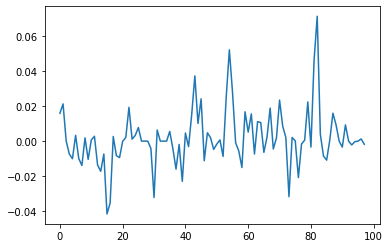

In [ ]:
import matplotlib.pyplot as plt
plt.plot(lrn.coef_[0][-100:-2])

In [ ]:
a,b=scoration("CEP63",lrn,dev_set,next_set)
b["gene"]=[p for p in b["protein"]]
tmp = []
for p in b["protein"].tolist():
  try:tmp.append(len(alldic[p]))
  except:tmp.append(0)
b["len"] = tmp
b[:50]
#b[b["real"]==True][:50]

,protein,score,real,train,rank,gene,len
15673,EPOP,1,False,False,1,EPOP,162
28794,PCDH17,1,False,False,2,PCDH17,128
7346,PPP1R3G,1,False,False,3,PPP1R3G,117
17348,SOX12,1,False,False,4,SOX12,188
7350,SLC52A2,1,False,False,5,SLC52A2,221
17350,TRIP4,1,False,False,6,TRIP4,425
39194,NEMF,1,False,False,7,NEMF,219
34880,SOCS1,1,False,False,8,SOCS1,353
7355,SLC8A1,1,False,False,9,SLC8A1,158
7356,LCOR,1,False,False,10,LCOR,238


#XGBoost

In [ ]:
import xgboost as xgb
#model =  xgb.XGBClassifier(objective="binary:logistic",eta=0.2)#squarederror")
model =  xgb.XGBRegressor(objective="reg:logistic",eta=0.2,reg_lambda=0.1,max_depth=10)#squarederror")

In [ ]:
model.load_model("model_210928_all.model")

In [ ]:
xs,y=make_csr(next_tuple,notnext_tuple)
model.fit(xs,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.2, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:logistic', random_state=0,
             reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

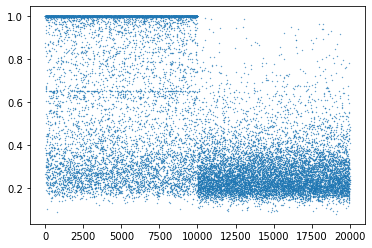

In [ ]:
xsp,yp=make_csr(dev_tuple2,notdevtuple_2)
preds = model.predict(xsp)
import matplotlib.pyplot as plt
plt.scatter(range(len(preds[:])),preds[:],s=0.1)

In [ ]:
g = "CEP57"
import pandas as pd
dev_set = set()#dev_tuple2)
next_set = set()#next_tuple)
a,b = scoration(g,model,dev_set,next_set,100,x=True)#x=Trueを忘れるなよ！
b[:50]#[b["real"]==True]

,protein,score,real,train,rank
16987,CEP63,0.998152,False,False,1
17476,CEP135,0.997710,False,False,2
11021,HOOK2,0.994378,False,False,3
13043,CEP192,0.992599,False,False,4
5976,CEP70,0.980360,False,False,5
26373,CLASP1,0.963058,False,False,6
11430,SSX2IP,0.961374,False,False,7
27587,CEP97,0.960266,False,False,8
930,CDK5RAP2,0.958612,False,False,9
7608,TPX2,0.958282,False,False,10


In [ ]:
b[b["real"]==True]

,protein,score,real,train,rank


In [ ]:
model.save_model('model_210928_all.model')

#手法の予測

In [10]:
#sent_210927_ex.csv
import random
def make_tuple4(path_to_csv,start,end,sampling=None,Nega=True):
  #data読み込み
  f = open(path_to_csv,"r")
  pa = True
  pmcid = []
  sentid = []
  genes = []
  expes=[]
  #データの読み取り
  for line in f:
    ls = line.strip().split(",")
    if ls[0].isnumeric():
      #Year Filter
      year = int(ls[0])
      if year > end or year < start:continue 
      #PMCID,sentid
      pmcid.append(ls[1])
      sentid.append(int(ls[2]))
      genes.append(ls[3])
      expes.append(ls[4])
  print("読み取り完了")
#処理
  next_tuple=[]
  notnext_tuple=[]
  raw = len(pmcid)
  for n,p in enumerate(pmcid):
    for n2 in range(1000):
      nn = n+n2 #二つ目の文章の番号
      if nn >= raw:break
      if p != pmcid[nn]: break #PMCID check
      if sentid[n]+1 < sentid[nn]: break #sent check

      if sentid[n] +1 == sentid[nn]: #条件に合致
         if genes[n].upper() in gene_to_sym and genes[nn].upper() in gene_to_sym: 
             g1 = gene_to_sym[genes[n].upper()]
             g2 = gene_to_sym[genes[nn].upper()]
             next_tuple.append((g1,g2,expes[nn]))
  return next_tuple



In [11]:
next_tuple_ex = make_tuple4("sent_210927_ex.csv",2010,2018)

読み取り完了


In [12]:
len(next_tuple_ex)

4410978

In [13]:
import random
next_tuple_ex2 = random.sample(next_tuple_ex,300000) 

In [14]:
xs,y=make_csr(next_tuple_ex2,[])

In [46]:
y = [a[2] for a in next_tuple_ex2]

In [54]:
#SGDClassifier
from sklearn.linear_model import SGDClassifier
lrn = SGDClassifier(loss='log',alpha=0.0001,penalty='l2')
lrn.fit(xs,y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [55]:
next_tuple_ex3 = random.sample(next_tuple_ex,10000) 
xs_d,y_d=make_csr(next_tuple_ex3,[])

In [59]:
pred = lrn.predict_proba(xs_d)
test = [a[2] for a in next_tuple_ex3]

kokd


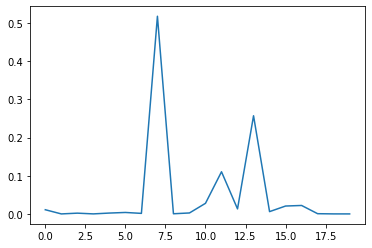

In [67]:
n = 41
plt.plot(pred[n])
print(test[n])

In [57]:
from sklearn.metrics import classification_report
print(classification_report(test, pred))

              precision    recall  f1-score   support

        bind       0.23      0.14      0.18       932
        elec       0.15      0.04      0.06        51
        fish       0.18      0.07      0.10       112
        gwas       0.00      0.00      0.00        11
        ihcc       0.15      0.02      0.03       288
        info       0.58      0.21      0.31       290
        kokd       0.47      0.80      0.59      3536
        live       1.00      0.08      0.14        13
        mass       0.38      0.19      0.25        89
        micr       0.36      0.29      0.32       886
        ngse       0.36      0.07      0.11       250
        othr       0.33      0.29      0.31      1215
        ovex       0.27      0.20      0.23      1317
        resc       0.38      0.02      0.04       145
        rtpc       0.28      0.14      0.19       551
        scre       0.06      0.01      0.02       109
        stru       0.29      0.12      0.17       111
        sumi       0.17    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
import pickle
with open("expred_2109.pickle","wb") as f:
  pickle.dump(lrn,f)

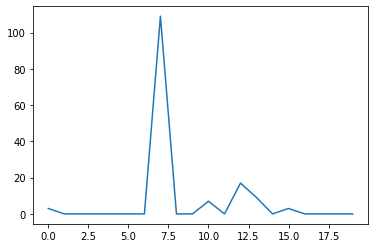

In [52]:
import matplotlib.pyplot as plt
plt.plot(confusion_matrix(test, pred)[14])

#下は学習モデルを作ったときの残骸

In [ ]:
ches = ""
chep = ""
t = 0
tmp2 = ""
import tqdm
import datetime
fw = open("sent_210927.csv","w")
for i in range(1,9):
  f = open("./2109_sentences/Part"+str(i)+"_bert_2109.csv","r")
  for line in tqdm.tqdm_notebook(f):
    t += 1
    ls = line.strip().split("\t")
    if chep != ls[2]:
      sentid = 0
      chep = ls[2]
    if ches != ls[-2]:
      ches = ls[-2]
      sentid += 1
    tmp = ",".join([ls[1],ls[2],str(sentid),ls[3].upper()])
    if tmp != tmp2:
      fw.write(tmp+"\n")
      tmp2 = tmp
    if t % 1000000 == 0:
      print(t,datetime.datetime.now())
  f.close()
fw.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


0it [00:00, ?it/s]

1000000 2021-09-27 15:09:25.134031


0it [00:00, ?it/s]

2000000 2021-09-27 15:09:30.536938


0it [00:00, ?it/s]

3000000 2021-09-27 15:09:37.439329


0it [00:00, ?it/s]

0it [00:00, ?it/s]

4000000 2021-09-27 15:09:46.829131
5000000 2021-09-27 15:09:52.942397


0it [00:00, ?it/s]

6000000 2021-09-27 15:10:00.860069


0it [00:00, ?it/s]

7000000 2021-09-27 15:10:08.263480


0it [00:00, ?it/s]

8000000 2021-09-27 15:10:14.872874


In [ ]:
import re
ches = ""
chep = ""
t = 0
tmp2 = ""
import tqdm
import datetime
fw = open("sent_210927_ex.csv","w")
for i in range(1,2):
  f = open("2109_sent_final.tsv","r")
  for line in tqdm.tqdm_notebook(f):
    t += 1
    ls = line.strip().split("\t")
    if chep != ls[2]:
      sentid = 0
      chep = ls[2]
    s = ls[-3]
    s = re.sub("<.*?>","",s)
    if ches != s:
      ches = s
      sentid += 1
    tmp = ",".join([ls[1],ls[2],str(sentid),ls[-1],ls[-2]])
    if tmp != tmp2:
      fw.write(tmp+"\n")
      tmp2 = tmp
    if t % 1000000 == 0:
      print(t,datetime.datetime.now())
  f.close()
fw.close()

#aa


In [69]:
a = "ceP57"
a.upper()

'CEP57'

In [77]:
l = ["あ",3,"5"] 